Modelling separation logic in Z3. I had something down below on that?
(heap-valid A Bool)
(heap A B)
Or
(heap A (Option B))

(is_heap_join h1 h2 h3) == ( forall x, h3 x = if (valid h1 x) then h1 x else h2 x,  forall x, valid h3 x => (valid h1) \/ (valid h2) , (valid h1) => valid h3, valid h2 => valid h3


The axiomatization is off in one respect. You need a default value. The array can't exist if there are no default values.
Every statement you want to make about stuff requires first that 

There is an analogy to be had that the `valid` array technique is natural. It feels a bit like the TLB or tagged architectures.

The memory of the computer is Array(BitVec(64), BitVec(8)) 
?

But we can pretend it's smaller for our purposes.
tlb_valid(  ) - hard to know as a user level C guy. C setsup some memory for you

malloc_valid()


papers that talk about memory models
alive2 paper
That instruction selection paper

Frama-C does something
dafny does something
viper does something

{valid(addr) /\  P[mem[addr]/a]}
a := memread(addr)
{P}

{P[store(assr,val,mem) /\  valid(addr)}
memwrite(addr,val)
P

{ exists q, [q -> 0, q + 1 -> 0, ... q + n -> 0] -* P[q/a] } Wand?
a = malloc(n)
{P }



Can I encode LTL formula to Z3?
Every variables becomes:
Array(IntSort(), BoolSort()) / Function(, IntSort(), BoolSort())
def next(p):
    lambda n: p(n + 1)
def eventually(p):
    return lambda n: Exists([m], Implies(m >= n , p(n) )
def always(p):
    return lambda n: ForAll([n], Implies(m >= n, p(n) )



class FixedPoint():
    intpart = FreshInt() / FreshConst(BitVec(64))
    realpart = FreshReal()
    
some kind of cegis? Given a choice of real factor, find worst counterexample in the int. Specing the int computation is tough though. I have no faith that Z3 is going to handle casting int to real well.


My valid, heap seperation is nice because boolector will support it.

In [152]:
# seperation logic

from z3 import *
import functools
# K = IntSort()  # seems to work fine.
def disjointunion(a,b,c):
    k = FreshConst(a.domain())
    return ForAll([k], And( Or(a[k], b[k]) == c[k],
                            Not(And(a[k],b[k]))
                          ))

# set diff is automatically the disjoint union. And doesn't use a quantifier. Nope nvm
def setdiff(c,a):
    return lambda k: And(c[k], Not(a[k])), ForAll([k], Implies(a[k], c[k])) 

# a seperating logic thing is in the context of a vlid memory region in the heap

def pto(k,v):
    def res(heap,valid):
        k1 = FreshConst(heap.domain())
        return And(
                   ForAll([k1], valid[k1] == (k1 == k)),
                   heap[k] == v
        )
    return res

def emp(heap,valid):
        k1 = FreshConst(heap.domain())
        return ForAll([k1], valid[k1] == False)
    
def sep(f,g):
    def res(heap,valid):
        a = FreshConst(valid.sort())
        b = FreshConst(valid.sort())
        # Should we existentially quantify a and b? We're assuming they'll reach a top level existential
        return Exists([a,b], And(disjointunion(a,b,valid), f(heap,a), g(heap,b)))
    return res

def lift(x):
    def res(heap,valid):
        return x
    return res

def cell(k, vals):
    return functools.reduce(sep, [ pto(k+n, v) for n,v in enumerate(vals)])
# http://www.cs.cmu.edu/afs/cs.cmu.edu/project/fox-19/member/jcr/www15818As2011/cs818A3-11.html
# If the heap is extended with a disjoint part in which p1 holds, then p2
# holds for the extended heap.
def wand(p1,p2):
    def res(heap,valid):
        v2 = FreshConst(valid.sort())
        v3 = FreshConst(valid.sort())
        # should we skolemize the sitantial into setdiff?
        # Or should we define h2 in terms of h3 and h1
        # Exists([h3], Implies(p1(setdiff(h3,h)), p2(h3)))
        # ForAll([v2], Implies(p1(v2),  p2(disjointunionfun())   ))
        return ForAll([v2], Exists([v3], Implies( And( p1(heap,v2) , disjointunion(valid,v2,v3)) ,  p2(heap, v3)   )))
    return res


In [143]:
import networkx as nx
def vis_check(pred, N = 3):
    s = Solver()
    K = BitVecSort(N)
    valid = Array("valid", K, BoolSort())
    heap = Array("heap", K, K)
    s.add(pred(heap,valid))
    #s.add(pto(1,0)(heap,valid))
    if s.check() == sat:
        m = s.model()
        #print(m)
        vals = range(2**N)
        #print(m.eval(BV2Int(heap[0])))
        #print(dir(m.eval(BV2Int(heap[0]))))
        try:
            edges = [ ( i , m.eval(heap[i]).as_long() )  for i in vals] #if bool(m.eval(valid[i])) ]
            colors = ["green" if bool(m.eval(valid[i])) else "white" for i in vals  ]
            #print(colors)
            G = nx.DiGraph()
            G.add_nodes_from(vals)
            G.add_edges_from(edges)
            nx.draw(G, with_labels=True, node_color = colors, font_weight='bold')
        except:
            pass
        return m
    else:
        print("unsat")

In [144]:
vis_check(sep(emp, emp))

[valid = K(BitVec(3), False)]

In [ ]:
def lst(p, l, N=3): #unroll list predicate
    for i in range(2**N):
        p2 = FreshConst(K)
        IfS( lift(isnil(l)) , pto(p, nil), ExistsS( [p2], cell(p, [head(l), p2]  ) ) )
        p = p2
# http://www.cs.cmu.edu/afs/cs.cmu.edu/project/fox-19/member/jcr/www15818As2011/cs818A3-11.html
# If the heap is extended with a disjoint part in which p1 holds, then p2
# holds for the extended heap.



In [ ]:
# PROVE LAWS


p1 = Function("p1", Array(), Array(), BoolSort())
p2 = Function("p1", Array(), Array(), BoolSort())
heap =
valid = 

prove(sep(p1,p2)(heap, valid) == sep(p2,p1)(heap,valid))

def prove_sep( pa, pb ):
    heap
    valid
    prove(Forall([heap,valid], pa(heap,valid) == pb(heap,valid)))

In [148]:
{**{1:2},  **{1:4}}

{1: 4}

In [151]:
def disjoint_merge(a, b):
    assert not any(k in b for k in a)
    return {**a, **b}

disjoint_merge({1:4}, {1:2})

AssertionError: 

In [92]:
def all_splits(l):
    n = len(l)
    for i in range(2**n):
        left = []
        right = []
        for b in range(n):
            if (i >> b) & 1 == 0:
                left.append(l[b])
            else:
                right.append(l[b])
        yield left, right

list(all_splits( range(3) ))

def emp(heap):
    return len(heap) == 0

def pto(k,v):
    def res(heap):
        return len(heap) == 1 and k in heap and heap[k] == v
    return res

def sep(p1,p2):
    def res(heap):
        for (l,r) in all_splits(list(heap.keys())):
            if p1( { k : heap[k] for k in l  } ) and p2( { k : heap[k] for k in r  } ):
                return True
        return False
    return res
        
def lift0(b): # lift a boolean
    return lambda heap: b
def lift1(boolop): # lift a unary boolean operation
    return lambda p: lambda heap: boolop(p(x))
def lift2(boolop): # lift a binary boolean operation
    return lambda p1,p2: lambda heap: boolop(p1(heap), p2(heap))

#ands = lift2( lambda x,y: x and y )

# short circuiting evaluation is rather nice
def ands(p1,p2):
    return lambda heap: p1(heap) and p2(heap)
def ors(p1,p2):
    return lambda heap: p1(heap) or p2(heap)
def impls(p1,p2):
    return lambda heap: not p1(heap) or p2(heap)
nots = lift1(lambda b : not b)
trues = lift0(True)
falses = lift0(False)


sep(pto(1,2), pto(2,3))({ 1:2,  2:3  }) # True
sep(pto(1,2), pto(2,3))({ 1:2,  2:3 , 4:5 }) # False
emp( {} ) # True
emp( {1 : 2} ) # False
pto(1,3)({1 : 3}) # True
pto(1,3)( {1 : 3, 4 : 5}    ) # False. Perhaps a little surprising. 1 Points to 3 means ONLY 1 -> 3 and nothing extra
ands( pto(1,2), pto(1,2) )({ 1 : 2}) # True
sep( pto(1,2), pto(1,2) )({ 1 : 2}) # False




False

In [ ]:
# a different represdentation. def pred(heap) -> option heap. Doing the set difference
# I guess it is still a search, but we can orient the search a different way. Kind of odd these two perspective are rellated.

def pto(k,v):
    def res(heap):
        if k in heap and heap[k] == v:
            del k in heap # should be doing it pure though
            return heap
        return None
    return res
        
def emp(heap): # hmnm. This is kind of intruguing. it's the identity function. Am I doing a yoneda? sep and emp form a monoid.
    return heap

def sep(p1,p2): # sep is kliesli compose for option
    def res(heap):
        heap1 = p1(heap)
        if heap != None:
            return p2(heap)
        return None
    return res

def ands(p1,p2):
    def res(heap):
        heap1 = p1(heap)
        if heap1 != None:
            heap2 = p2(heap)
            if heap2 != None:
                return heap1 == heap2 # is this right? Kind of in parallel.
        return None
    return res

def ors(p1, p2): # hmm. Looks like we want it to return [heaps]
    def res(heap):
        heaps1 = p1(heap)
        heaps2 = p2(heap)
        return heaps1 + heaps2
        # yield from heaps1
    return res


#so should we be looking for an empty heap output?
# emp returns same heap. 
# pto - yes
# True = returns all possible subheaps?
# False = []
# 
# i can probably read this rules off of a paper somewhere.
#Should I be doing this in prolog? 
# model(sep(P,Q), Heap) :- disjointmerge(H1,H2,Heap), model(P, H1), model(Q, H2).
# model(emp, []).
# model(pto(K,V), [K - V]).
# model(and(P1,P2), Heap ) :- model(P1, Heap), model(P2, Heap). % very metainterpeter feeling
# model(or(P1,P2), Heap) :- model(P1, Heap) ; modell(P2, Heap).

# Hmm. If I can do this in prolog, should I use Z3 FixedPoint? Maybe if i wanted to infer predicates that describe heaps? But if I'm doing - + mode or - - mode then 



In [ ]:
# The garbage collector
import gc

In [106]:
# physical equality

x = [1,2,3]
y = x
y is x # True

x = [1,2,3]
y = [1,2,3]
y is x # False

import copy
x = [1,2,3]
y = copy.copy(x)
y is x # False


def alias(x,y):
    return x is y

def noalias(x,y):
    return not x is y

def inc2(x,y):
    assert noalias(x,y)
    oldx = x[0]
    oldy = y[0]
    x[0] = x[0] + 1
    y[0] = y[0] + 1
    assert x[0] == oldx + 1 and y[0] == oldy + 1
    return x, y

inc2([2],[2]) # returns [3], [3]

inc2(x,x) # noalias assert fails

AssertionError: 

In [110]:
import networkx as nx
def vis_check(pred, N = 3):
    s = Solver()
    K = BitVecSort(N)
    valid = Array("valid", K, BoolSort())
    heap = Array("heap", K, K)
    s.add(pred(heap,valid))
    #s.add(pto(1,0)(heap,valid))
    if s.check() == sat:
        m = s.model()
        #print(m)
        vals = range(2**N)
        edges = [ ( i , m.eval(heap[i]).as_long() )  for i in vals] #if bool(m.eval(valid[i])) ]
        colors = ["green" if bool(m.eval(valid[i])) else "white" for i in vals  ]
        #print(colors)
        G = nx.DiGraph()
        G.add_nodes_from(vals)
        G.add_edges_from(edges)
        nx.draw(G, with_labels=True, node_color = colors, font_weight='bold')
        return m
    else:
        print("unsat")
    
    

In [112]:
vis_check(wand(emp, emp))

TypeError: res() takes 1 positional argument but 2 were given

[heap = Store(K(BitVec(3), 1), 2, 0),
 valid = Lambda(k!0,
                Or(k!0 == 0, And(k!0 == 2, Not(k!0 == 0)))),
 Ext = [(as-array, as-array) -> 2, else -> 0],
 k!1820 = [else ->
           Or(Var(0) == 0,
              And(Var(0) == 2, Not(Var(0) == 0)))],
 k!1819 = [else -> Var(0) == 0]]

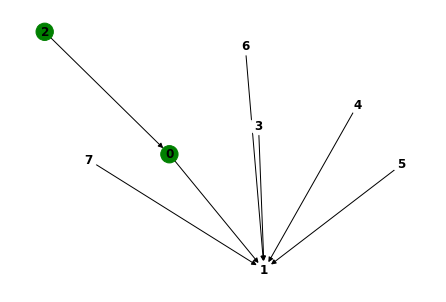

In [153]:
vis_check(sep(pto(0,1), pto(2,0)))

In [154]:
vis_check(sep(pto(0,1), pto(0,1)))

unsat


[c!938 = Lambda(k!0, And(k!0 == 1, Not(k!0 == 0))),
 c!937 = Lambda(k!0, k!0 == 0),
 heap = Store(K(BitVec(3), 1), 1, 0),
 valid = Lambda(k!0,
                Or(k!0 == 0, And(k!0 == 1, Not(k!0 == 0)))),
 k!962 = [else -> Var(0) == 0],
 Ext = [(as-array, as-array) -> 1,
        (as-array, as-array) -> 1,
        else -> 0],
 k!964 = [else ->
          Or(Var(0) == 0,
             And(Var(0) == 1, Not(Var(0) == 0)))],
 k!963 = [else -> And(Var(0) == 1, Not(Var(0) == 0))]]

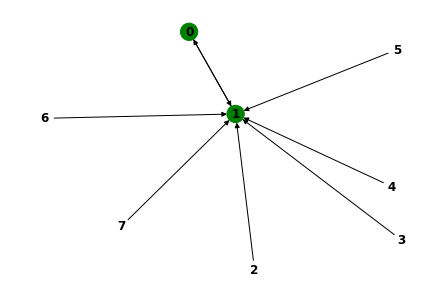

In [59]:
vis_check(sep(pto(0,1), pto(1,0)))

2
4


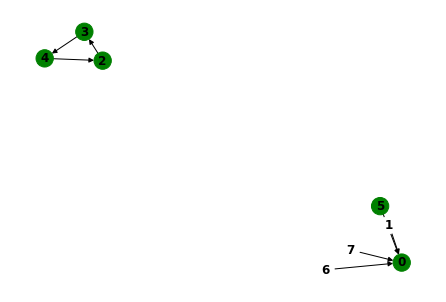

In [158]:
K = BitVecSort(3)
x, y = Consts("x y" ,K)
nil = 0
m = vis_check( sep(pto(nil,nil), sep(cell(x, [3, y] ) , cell(y, [2, nil] ))))
print(m[x])
print(m[y])

0
None


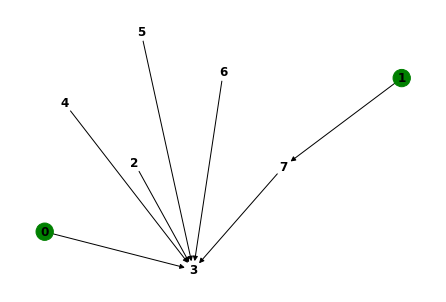

In [156]:
K = BitVecSort(3)
x, y = Consts("x y" ,K)
nil = 0
m = vis_check( cell(x, [3, 7] ) )
print(m[x])
print(m[y])

0
None


[x = 0,
 valid = Lambda(k!0,
                Or(k!0 == 0, And(k!0 == 1, Not(k!0 == 0)))),
 heap = Store(K(BitVec(3), 3), 1, 7),
 Ext = [(as-array, as-array) -> 1, else -> 0],
 k!2011 = [else -> Var(0) == 0],
 k!2013 = [else ->
           Or(Var(0) == 0,
              And(Var(0) == 1, Not(Var(0) == 0)))]]

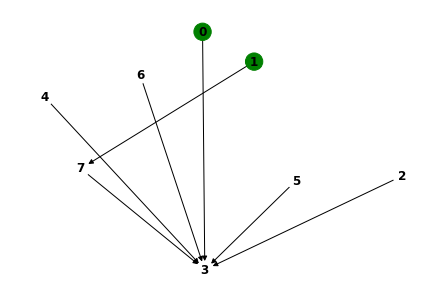

In [157]:
K = BitVecSort(3)
x, y = Consts("x y" ,K)
nil = 0
m = vis_check( sep(pto(x, 3), pto(x+1,7) ) )
print(m[x])
print(m[y])
m

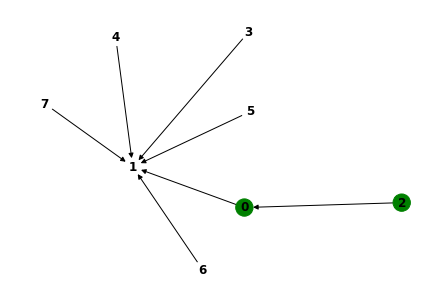

In [38]:
s = Solver()
N = 3
K = BitVecSort(N)
valid = Array("valid", K, BoolSort())
heap = Array("heap", K, K)
s.add(sep(pto(0,1), pto(2,0))(heap,valid))
#s.add(pto(1,0)(heap,valid))
if s.check() == sat:
    m = s.model()
    vals = range(2**N)
    edges = [ ( i , m.eval(heap[i]).as_long() )  for i in vals] #if bool(m.eval(valid[i])) ]
    colors = ["green" if bool(m.eval(valid[i])) else "white" for i in vals  ]

    import networkx as nx
    G = nx.DiGraph()
    G.add_edges_from(edges)

    nx.draw(G, with_labels=True, node_color = colors, font_weight='bold')
else:
    print("unsat")


In [17]:
bool(BoolVal(True))

True

In [ ]:
a = Array("a", K, BoolSort())
b = Array("b", K, BoolSort())
c = Array("c", K, BoolSort())
s = Solver()
s.add(disjointunion(a,b,c))
s.add(c[1])
s.add(b[1])
s.add(a[2])
#s.add(b[2])
s.check()
m = s.model()
print( [ m.eval(c[n]) for n in range(2**4)] )
print( [ m.eval(a[n]) for n in range(2**4)] )